In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Introduction
Greetings, in this section I will show you to see some insight we can obtain by the sales and sales forecasrting. We will also see the overall sales data to be displayed in some graphs.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

# Import and compile all data

In [4]:
factmarketsales = pd.read_excel('FactMarketSales.xlsx')
orders = pd.read_excel('Orders.xlsx')
products = pd.read_excel('Products.xlsx')
shippings = pd.read_excel('Shippings.xlsx')

In [5]:
df_all = factmarketsales.merge(orders,on='OrderCode').merge(products,on='ProductId').merge(shippings,on='OrderCode')
df_all.head(5)

,OrderCode,ProductId,ShipKey_x,Cust_id,Sales,Quantity,Discount,Profit,Shipping Cost,OrderKey,OrderPriority,OrderDate,ProductKey,Category,SubCategory,ProductName,ShipKey_y,ShipMode,ShipDate,ShippingRegion
0,Ord_1,1,1,Cust_1818,408.300,2,0.0,106.140,35.46,1,Medium,2011-01-01 00:00:00,1,Office Supplies,Storage,"Tenex Lockers, Blue",1,Standard Class,2011-06-01 00:00:00,Africa
1,Ord_2,2,2,Cust_1818,120.366,3,0.1,36.036,9.72,2,Medium,2011-01-01 00:00:00,2,Office Supplies,Supplies,"Acme Trimmer, High Speed",2,Standard Class,2011-08-01 00:00:00,Oceania
2,Ord_3,3,3,Cust_1818,66.120,4,0.0,29.640,8.17,3,High,2011-01-01 00:00:00,3,Office Supplies,Storage,"Tenex Box, Single Width",3,Second Class,2011-05-01 00:00:00,EMEA
3,Ord_4,4,4,Cust_1818,44.865,3,0.5,-26.055,4.82,4,High,2011-01-01 00:00:00,4,Office Supplies,Storage,Product SCD test1,4,Second Class,2011-05-01 00:00:00,North
4,Ord_5,5,5,Cust_1818,113.670,5,0.1,37.770,4.70,5,Medium,2011-01-01 00:00:00,5,Furniture,Furnishings,"Eldon Light Bulb, Duo Pack",5,Standard Class,2011-08-01 00:00:00,Oceania


Since we wanted to know the performance by using time series, then we need to split the date and time from column 'OrderDate' respectively.

In [6]:
df_all['OrderDate']=pd.to_datetime(df_all['OrderDate'])
df_all['ShipDate']=pd.to_datetime(df_all['ShipDate'])
df_all['Date Order'] = [d.date() for d in df_all['OrderDate']]
df_all['Time Order'] = [d.time() for d in df_all['OrderDate']]
df_all['Date Order']=pd.to_datetime(df_all['Date Order'])
df_all.head(5)

,OrderCode,ProductId,ShipKey_x,Cust_id,Sales,Quantity,Discount,Profit,Shipping Cost,OrderKey,...,ProductKey,Category,SubCategory,ProductName,ShipKey_y,ShipMode,ShipDate,ShippingRegion,Date Order,Time Order
0,Ord_1,1,1,Cust_1818,408.300,2,0.0,106.140,35.46,1,...,1,Office Supplies,Storage,"Tenex Lockers, Blue",1,Standard Class,2011-06-01,Africa,2011-01-01,00:00:00
1,Ord_2,2,2,Cust_1818,120.366,3,0.1,36.036,9.72,2,...,2,Office Supplies,Supplies,"Acme Trimmer, High Speed",2,Standard Class,2011-08-01,Oceania,2011-01-01,00:00:00
2,Ord_3,3,3,Cust_1818,66.120,4,0.0,29.640,8.17,3,...,3,Office Supplies,Storage,"Tenex Box, Single Width",3,Second Class,2011-05-01,EMEA,2011-01-01,00:00:00
3,Ord_4,4,4,Cust_1818,44.865,3,0.5,-26.055,4.82,4,...,4,Office Supplies,Storage,Product SCD test1,4,Second Class,2011-05-01,North,2011-01-01,00:00:00
4,Ord_5,5,5,Cust_1818,113.670,5,0.1,37.770,4.70,5,...,5,Furniture,Furnishings,"Eldon Light Bulb, Duo Pack",5,Standard Class,2011-08-01,Oceania,2011-01-01,00:00:00


# Some descriptions about the data

In [7]:
df_all.describe().drop(['ProductId','OrderKey','ProductKey','ShipKey_y'],axis=1)

,ShipKey_x,Sales,Quantity,Discount,Profit,Shipping Cost
count,51290.00000,51290.000000,51290.000000,51290.000000,51290.000000,51290.000000
mean,25645.50000,246.490581,3.476545,0.142908,28.610982,26.375915
std,14806.29199,487.565361,2.278766,0.212280,174.340972,57.296804
min,1.00000,0.444000,1.000000,0.000000,-6599.978000,0.000000
25%,12823.25000,30.758625,2.000000,0.000000,0.000000,2.610000
50%,25645.50000,85.053000,3.000000,0.000000,9.240000,7.790000
75%,38467.75000,251.053200,5.000000,0.200000,36.810000,24.450000
max,51290.00000,22638.480000,14.000000,0.850000,8399.976000,933.570000


In [8]:
df_all.columns

Index(['OrderCode', 'ProductId', 'ShipKey_x', 'Cust_id', 'Sales', 'Quantity',
       'Discount', 'Profit', 'Shipping Cost', 'OrderKey', 'OrderPriority',
       'OrderDate', 'ProductKey', 'Category', 'SubCategory', 'ProductName',
       'ShipKey_y', 'ShipMode', 'ShipDate', 'ShippingRegion', 'Date Order',
       'Time Order'],
      dtype='object')

# Gain some graphical insight
let's see how some values obtained by transaction in time

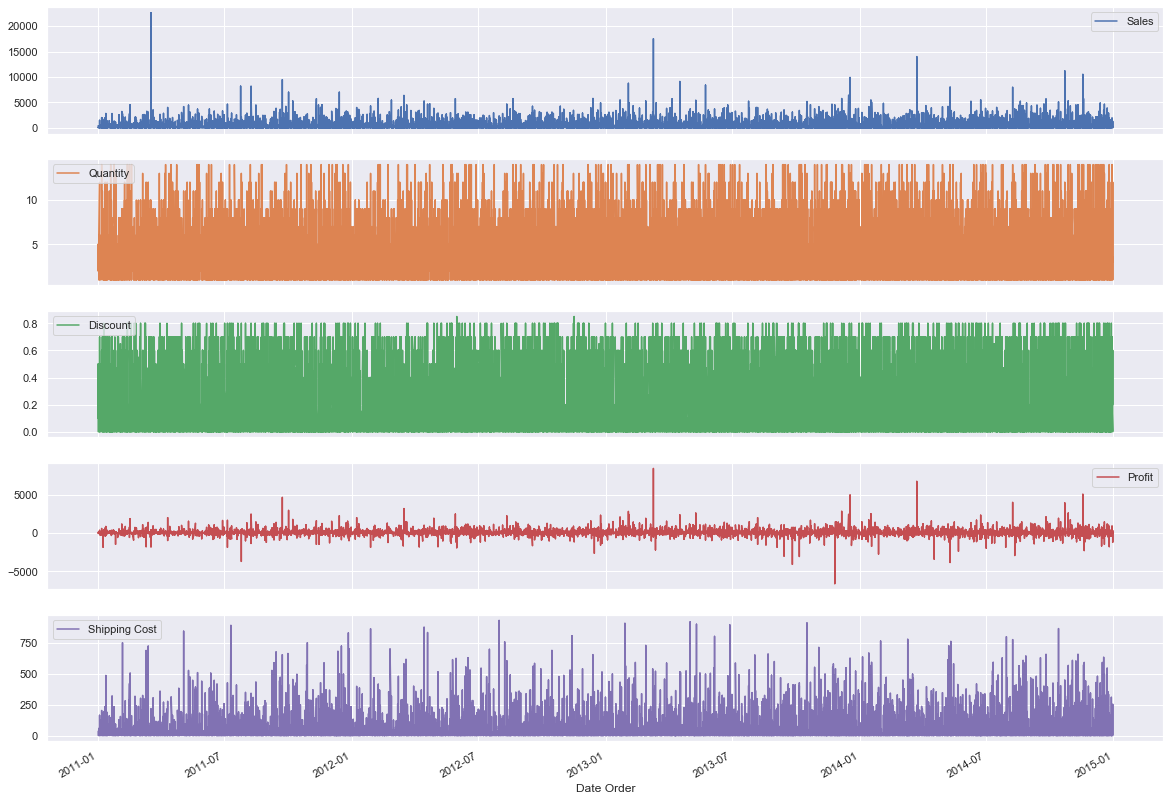

In [9]:
df_all[['Sales', 'Quantity','Discount', 'Profit', 'Shipping Cost','Date Order']].plot(x='Date Order',kind='line', subplots=True, figsize=(20,15))
plt.show()

Let's take a look at overall sales performance

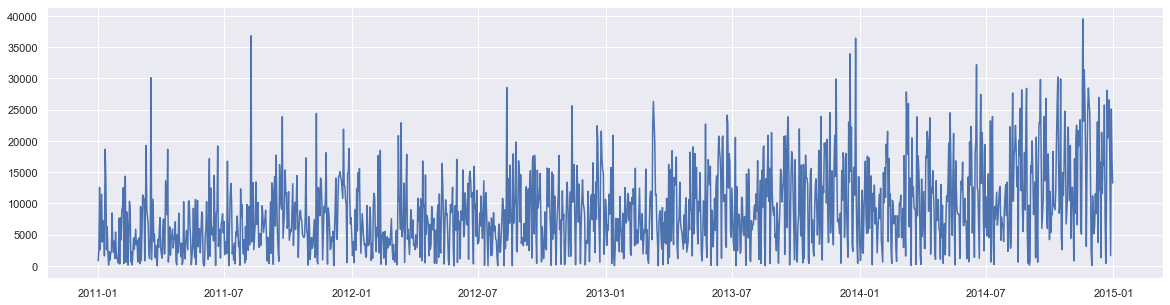

In [10]:
df_average_sales_month = df_all.groupby(by=['Date Order'], as_index=False)['Sales'].sum()
df_average_sales = df_average_sales_month.sort_values('Sales', ascending=False)

plt.figure(figsize=(20,5))
plt.plot(df_average_sales_month['Date Order'], df_average_sales_month['Sales'])
plt.show()

# Sales insight by categories

In [11]:
# The more remunerative
df_average_sales.head()

,Date Order,Sales
1386,2014-11-18,39536.13200
212,2011-08-09,36827.74592
1063,2013-12-26,36435.14374
1055,2013-12-18,33934.38260
1236,2014-06-18,32197.37604


In [12]:
# The least remunerative
df_average_sales[::-1].head()

,Date Order,Sales
144,2011-06-02,2.688
492,2012-05-27,11.448
933,2013-08-18,24.072
541,2012-07-15,26.892
80,2011-03-27,29.814


In [13]:
# Top performing type of Sub Category in term of sales
df_top_stores = df_all.groupby(by=['SubCategory'], as_index=False)['Sales'].sum()
df_top_stores.sort_values('Sales', ascending=False).head(5)

,SubCategory,Sales
13,Phones,1.706824e+06
6,Copiers,1.509436e+06
5,Chairs,1.501682e+06
4,Bookcases,1.466572e+06
14,Storage,1.127131e+06


In [14]:
# Top performing type of Shipping Region in term of sales
df_top_stores = df_all.groupby(by=['ShippingRegion'], as_index=False)['Sales'].sum()
df_top_stores.sort_values('Sales', ascending=False).head(5)

,ShippingRegion,Sales
3,Central,2.822303e+06
10,South,1.600907e+06
7,North,1.248166e+06
9,Oceania,1.100185e+06
11,Southeast Asia,8.844232e+05


In [15]:
# Top performing type of Order Priority in term of sales
df_top_stores = df_all.groupby(by=['OrderPriority'], as_index=False)['Sales'].sum()
df_top_stores.sort_values('Sales', ascending=False).head()

,OrderPriority,Sales
3,Medium,7.280892e+06
1,High,3.807548e+06
0,Critical,9.862355e+05
2,Low,5.678259e+05


# Forecast of Total Sales Volume

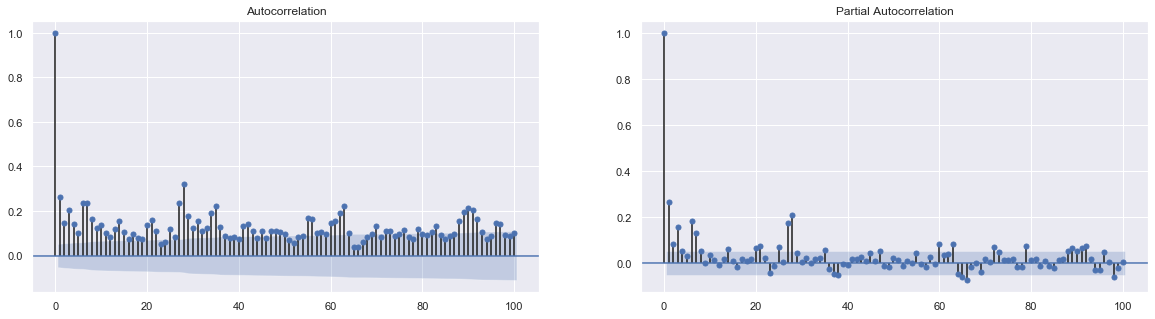

In [16]:
#Foreast of total sales volume
ts = df_average_sales_month.set_index('Date Order')
from statsmodels.graphics.tsaplots import acf, pacf, plot_acf, plot_pacf

fig, axes = plt.subplots(1,2, figsize=(20,5))
plot_acf(ts, lags=100, ax=axes[0])
plot_pacf(ts, lags=100, ax=axes[1])
plt.show()

In [17]:
from sklearn.linear_model import LinearRegression

def fit_ar_model(ts, orders):
    
    X=np.array([ ts.values[(i-orders)].squeeze() if i >= np.max(orders) else np.array(len(orders) * [np.nan]) for i in range(len(ts))])
    
    mask = ~np.isnan(X[:,:1]).squeeze()
    
    Y= ts.values
    
    lin_reg=LinearRegression()
    
    lin_reg.fit(X[mask],Y[mask])
    
    print(lin_reg.coef_, lin_reg.intercept_)

    print('Score factor: %.2f' % lin_reg.score(X[mask],Y[mask]))
    
    return lin_reg.coef_, lin_reg.intercept_
    
def predict_ar_model(ts, orders, coef, intercept):
    return np.array([np.sum(np.dot(coef, ts.values[(i-orders)].squeeze())) + intercept  if i >= np.max(orders) else np.nan for i in range(len(ts))])

[[0.23813861 0.20733227 0.03054311]] [4736.28218167]
Score factor: 0.11


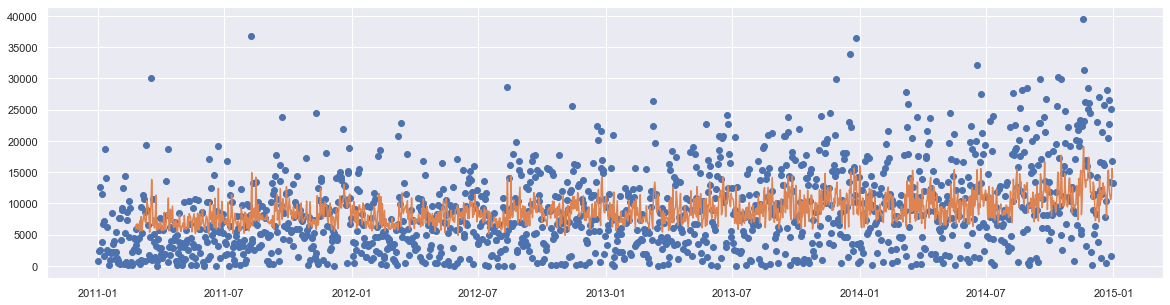

In [18]:
orders=np.array([1,6,52])
coef, intercept = fit_ar_model(ts,orders)
pred=pd.DataFrame(index=ts.index, data=predict_ar_model(ts, orders, coef, intercept))
plt.figure(figsize=(20,5))
plt.plot(ts, 'o')
plt.plot(pred)
plt.show()

AR Residuals: avg -6.81, std 71.54


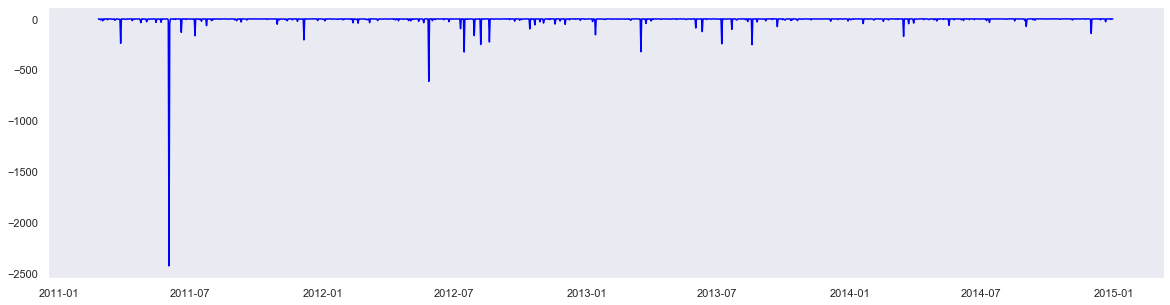

In [19]:
diff=(ts['Sales']-pred[0])/ts['Sales']

print('AR Residuals: avg %.2f, std %.2f' % (diff.mean(), diff.std()))
 
plt.figure(figsize=(20,5))
plt.plot(diff, c='blue')
plt.grid()
plt.show()

In [20]:
#Forecast of the store-wise sales volume
#Develop the forecast model for the phone, which shows the highest sales volume.

df_phone=df_all.where(df_all['SubCategory'] == 'Phones')
df_phone=df_phone.dropna()
df_phone=df_phone.groupby(by=['Date Order'], as_index=False)['Sales'].sum()
df_phone = df_phone.set_index('Date Order')
df_phone.head()

,Sales
Date Order,
2011-01-03,591.012
2011-01-04,635.280
2011-01-06,1316.293
2011-01-07,575.920
2011-01-09,1238.100


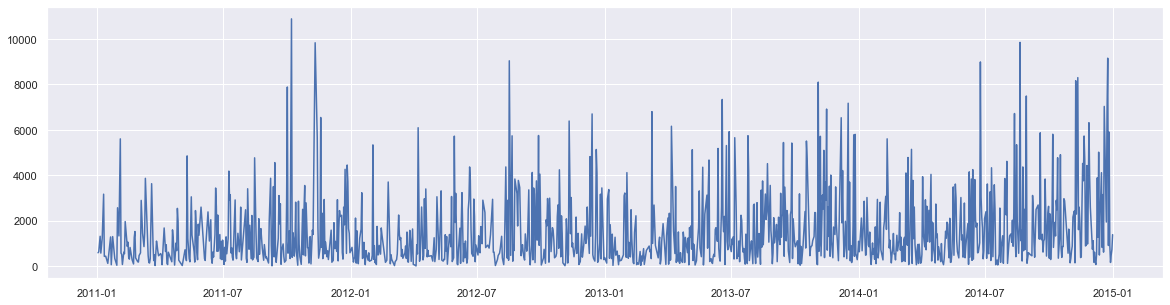

In [21]:
plt.figure(figsize=(20,5))
plt.plot(df_phone.index, df_phone.values)
plt.show()

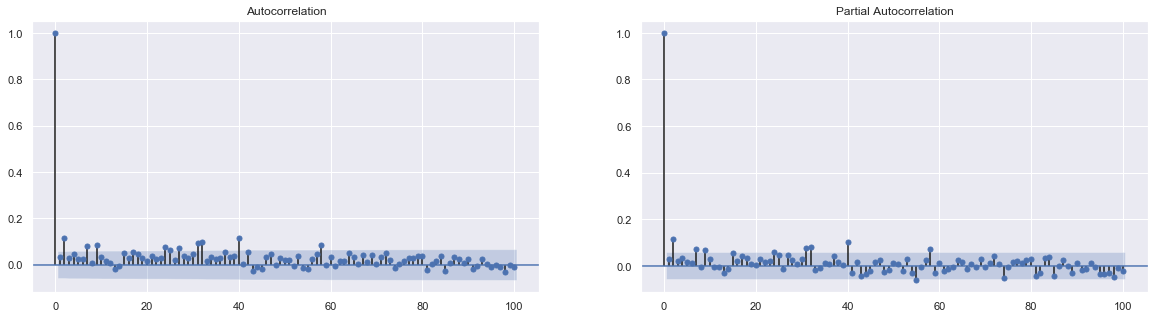

In [22]:
fig, axes = plt.subplots(1,2, figsize=(20,5))
plot_acf(df_phone.values, lags=100, alpha=0.05, ax=axes[0])
plot_pacf(df_phone.values, lags=100, alpha=0.05, ax=axes[1])
plt.show()

[[ 0.02483691  0.01382134  0.02944949  0.03409238 -0.01079924]] [1391.10803887]
Score factor: 0.00


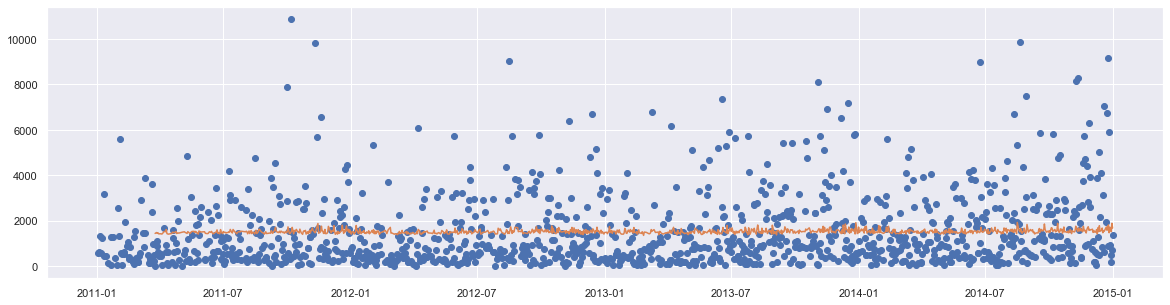

In [23]:
orders=np.array([1,6,29,46,52])
coef, intercept = fit_ar_model(df_phone,orders)
pred=pd.DataFrame(index=df_phone.index, data=predict_ar_model(df_phone, orders, coef, intercept))
plt.figure(figsize=(20,5))
plt.plot(df_phone, 'o')
plt.plot(pred)
plt.show()

AR Residuals: avg -2.80, std 7.72


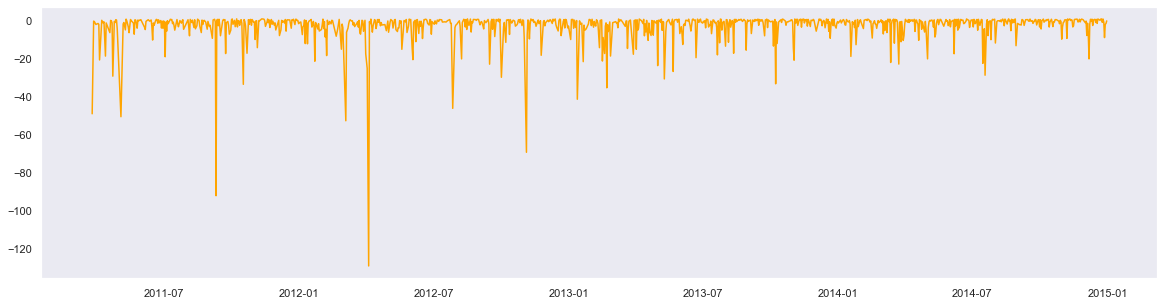

In [24]:
diff=(df_phone['Sales']-pred[0])/df_phone['Sales']

print('AR Residuals: avg %.2f, std %.2f' % (diff.mean(), diff.std()))
 
plt.figure(figsize=(20,5))
plt.plot(diff, c='orange')
plt.grid()
plt.show()

# Look for predictive power from external variables

In [25]:
dfext=df_all.where( df_all['SubCategory'] == 'Phones')
dfext=dfext.dropna()
dfext=dfext.groupby(by=['Date Order'], as_index=False)[['Sales', 'Quantity','Discount', 'Profit', 'Shipping Cost']].mean()
dfext = dfext.set_index('Date Order')
dfext.head()

,Sales,Quantity,Discount,Profit,Shipping Cost
Date Order,,,,,
2011-01-03,197.004000,2.666667,0.133333,26.2986,10.856667
2011-01-04,317.640000,4.000000,0.400000,-157.6500,71.525000
2011-01-06,438.764333,3.666667,0.050000,136.0216,56.970000
2011-01-07,575.920000,2.000000,0.200000,71.9900,93.100000
2011-01-09,619.050000,3.500000,0.000000,91.3650,54.750000


In [26]:
dfext.describe()

,Sales,Quantity,Discount,Profit,Shipping Cost
count,1134.000000,1134.000000,1134.000000,1134.000000,1134.000000
mean,505.295110,3.560918,0.143383,65.674233,54.136925
std,516.851492,1.720136,0.138525,168.796873,62.739152
min,10.950000,1.000000,0.000000,-699.780000,0.180000
25%,221.939667,2.500000,0.000000,7.329375,19.656000
50%,360.921375,3.267857,0.111250,42.837433,36.520000
75%,601.562625,4.276786,0.200000,96.708600,65.092500
max,5737.500000,14.000000,0.700000,2461.320000,665.270000


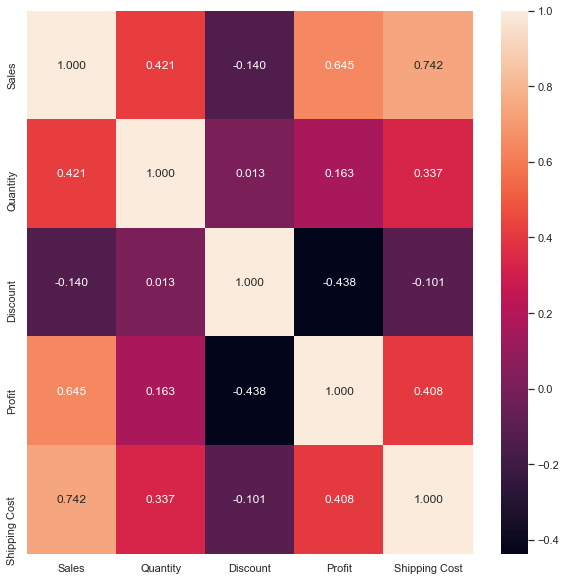

In [27]:
import seaborn as sns
corr = dfext.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, 
            annot=True, fmt=".3f",
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

In [28]:
corr['Sales'].sort_values(ascending=False)

Sales            1.000000
Shipping Cost    0.741852
Profit           0.645310
Quantity         0.420550
Discount        -0.139544
Name: Sales, dtype: float64